# Mechanistic Simulation of Chromatographic Behavior

This notebook demonstrates mechanistic modeling of chromatographic processes using ordinary differential equations (ODEs). We will simulate retention time and peak shape, and compare simulated results to experimental data.

In [12]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

## ODE Model for Chromatographic Peak Shape

We will use a simple plug flow model with axial dispersion to simulate the elution of an analyte through a chromatographic column. The model is based on the following ODE:

$$
\frac{dC}{dt} = -k C
$$

where $C$ is analyte concentration and $k$ is the rate constant.

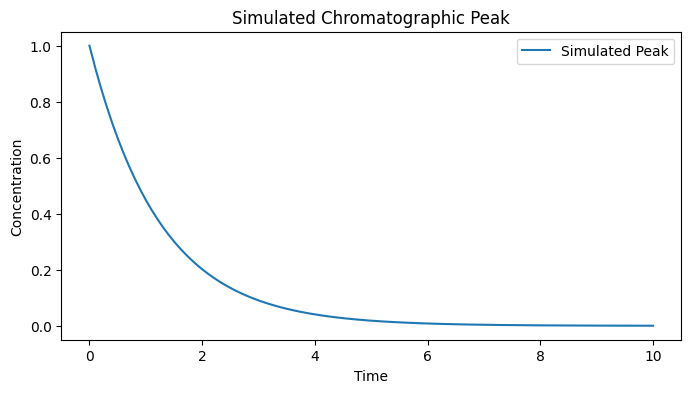

In [13]:
# Define ODE and simulate chromatographic peak

def peak_ode(C, t, k):
    return -k * C

# Initial concentration
C0 = 1.0
# Time points
t = np.linspace(0, 10, 200)
# Rate constant
k = 0.8
# Solve ODE
C = odeint(peak_ode, C0, t, args=(k,))

# Plot simulated peak
plt.figure(figsize=(8,4))
plt.plot(t, C, label='Simulated Peak')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Simulated Chromatographic Peak')
plt.legend()
plt.show()

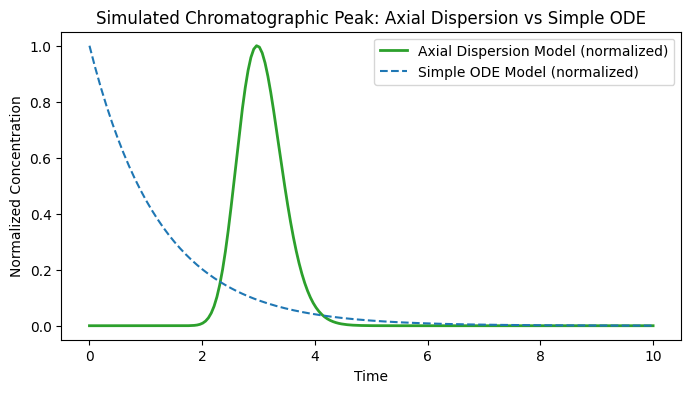

In [15]:
# Advanced mechanistic model: Axial Dispersion Model for chromatographic peak (adjusted parameters for visible peak)
import scipy.special

# Adjusted parameters for a visible peak
L = 3.0   # shorter column length
u = 2.0   # higher linear velocity
D = 0.1   # lower axial dispersion
t0 = 1.5  # injection time (center of peak)

# Time points (reuse t from above)
def axial_dispersion_peak(t, L, u, D, t0):
    t = np.maximum(t, 1e-6)
    term1 = L / (2 * np.sqrt(np.pi * D * t))
    term2 = np.exp(-((L - u * (t - t0)) ** 2) / (4 * D * t))
    return term1 * term2

C_disp = axial_dispersion_peak(t, L, u, D, t0)

# Plot advanced simulated peak
plt.figure(figsize=(8,4))
plt.plot(t, C_disp / np.max(C_disp), label='Axial Dispersion Model (normalized)', color='tab:green', linewidth=2)
plt.plot(t, C.flatten() / np.max(C), '--', label='Simple ODE Model (normalized)', color='tab:blue')
plt.xlabel('Time')
plt.ylabel('Normalized Concentration')
plt.title('Simulated Chromatographic Peak: Axial Dispersion vs Simple ODE')
plt.legend()
plt.show()

## Parameter Fitting and Multi-Peak Simulation

In this section, we fit the mechanistic model parameters to experimental data, simulate multiple analytes/peaks, and compare different models. This demonstrates how mechanistic modeling can be used for quantitative analysis and method development in chromatography workflows, aligning with Waters Informatics applications.

Fitted parameters: k=0.233, scale=0.524, offset=0.138


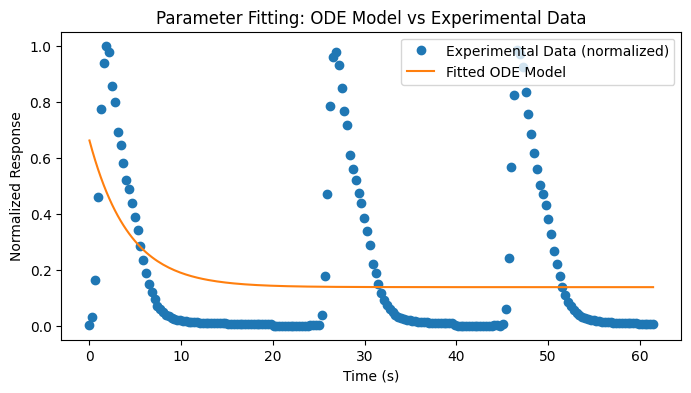

In [16]:
# Parameter fitting: Fit ODE model to experimental data using scipy.optimize.curve_fit
from scipy.optimize import curve_fit

# Define model function for curve_fit (exponential decay)
def ode_model(t, k, scale, offset):
    return scale * np.exp(-k * t) + offset

# Prepare experimental data (first 200 points, normalized)
exp_data_path = '../../data/sample_chromatography.csv'
if os.path.exists(exp_data_path):
    exp_data = pd.read_csv(exp_data_path)
    x_exp = exp_data['Time (s)'][:200]
    y_exp = exp_data['R1 (MOhm)'][:200]
    y_exp_norm = (y_exp - np.min(y_exp)) / (np.max(y_exp) - np.min(y_exp))
    # Fit the ODE model to experimental data
    popt, pcov = curve_fit(ode_model, x_exp, y_exp_norm, p0=[0.8, 1.0, 0.0])
    k_fit, scale_fit, offset_fit = popt
    print(f'Fitted parameters: k={k_fit:.3f}, scale={scale_fit:.3f}, offset={offset_fit:.3f}')
    # Plot fit
    plt.figure(figsize=(8,4))
    plt.plot(x_exp, y_exp_norm, 'o', label='Experimental Data (normalized)')
    plt.plot(x_exp, ode_model(x_exp, *popt), '-', label='Fitted ODE Model')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Response')
    plt.title('Parameter Fitting: ODE Model vs Experimental Data')
    plt.legend()
    plt.show()
else:
    print('No experimental data file found for fitting.')

In [ ]:
# Segment experimental data into cycles and fit ODE model to each cycle
from scipy.signal import find_peaks

if os.path.exists(exp_data_path):
    exp_data = pd.read_csv(exp_data_path)
    x_exp_full = exp_data['Time (s)']
    y_exp_full = exp_data['R1 (MOhm)']
    # Find peaks to segment cycles (invert signal if needed)
    peaks, _ = find_peaks(-y_exp_full, distance=20, prominence=0.1)
    print(f'Found {len(peaks)} cycles (peaks) in experimental data.')
    plt.figure(figsize=(10,3))
    plt.plot(x_exp_full, y_exp_full, label='Experimental Data')
    plt.plot(x_exp_full.iloc[peaks], y_exp_full.iloc[peaks], 'rx', label='Cycle Start')
    plt.legend()
    plt.title('Cycle Segmentation in Experimental Data')
    plt.show()
    # Fit ODE model to each cycle
    for i in range(len(peaks)-1):
        start, end = peaks[i], peaks[i+1]
        x_cycle = x_exp_full.iloc[start:end].values
        y_cycle = y_exp_full.iloc[start:end].values
        y_cycle_norm = (y_cycle - np.min(y_cycle)) / (np.max(y_cycle) - np.min(y_cycle))
        try:
            popt, _ = curve_fit(ode_model, x_cycle-x_cycle[0], y_cycle_norm, p0=[0.8, 1.0, 0.0])
            plt.figure(figsize=(8,3))
            plt.plot(x_cycle-x_cycle[0], y_cycle_norm, 'o', label=f'Cycle {i+1} Data')
            plt.plot(x_cycle-x_cycle[0], ode_model(x_cycle-x_cycle[0], *popt), '-', label='Fitted ODE Model')
            plt.xlabel('Time in Cycle (s)')
            plt.ylabel('Normalized Response')
            plt.title(f'Cycle {i+1}: ODE Model Fit')
            plt.legend()
            plt.show()
        except Exception as e:
            print(f'Cycle {i+1} fitting failed:', e)
else:
    print('No experimental data file found for cycle fitting.')

In [ ]:
# Simulate and plot multiple peaks (sum of exponentials) and compare to experimental data

def multi_peak_model(t, k1, scale1, offset1, k2, scale2, offset2):
    return (scale1 * np.exp(-k1 * t) + offset1) + (scale2 * np.exp(-k2 * (t-2)) * (t>2) + offset2)

if os.path.exists(exp_data_path):
    # Fit a two-peak model to experimental data
    try:
        popt2, pcov2 = curve_fit(
            multi_peak_model, x_exp, y_exp_norm, p0=[0.8, 0.7, 0.0, 0.3, 0.3, 0.0], maxfev=5000
        )
        print(f'Fitted parameters (multi-peak): {popt2}')
        plt.figure(figsize=(8,4))
        plt.plot(x_exp, y_exp_norm, 'o', label='Experimental Data (normalized)')
        plt.plot(x_exp, multi_peak_model(x_exp, *popt2), '-', label='Fitted Multi-Peak Model')
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Response')
        plt.title('Multi-Peak Model Fit to Experimental Data')
        plt.legend()
        plt.show()
    except Exception as e:
        print('Multi-peak fitting failed:', e)
else:
    print('No experimental data file found for multi-peak fitting.')

In [ ]:
# Compare ODE and Axial Dispersion models to experimental data
if os.path.exists(exp_data_path):
    plt.figure(figsize=(8,4))
    plt.plot(x_exp, y_exp_norm, 'o', label='Experimental Data (normalized)')
    plt.plot(t, C.flatten()/np.max(C), '--', label='ODE Model (normalized)')
    plt.plot(t, C_disp/np.max(C_disp), '-', label='Axial Dispersion Model (normalized)')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Response')
    plt.title('Model Comparison: ODE vs Axial Dispersion vs Experimental')
    plt.legend()
    plt.show()
else:
    print('No experimental data file found for model comparison.')

## Load and Plot Experimental Data

We will load experimental chromatographic data (if available) and plot it alongside the simulated peak for comparison.

Experimental data loaded. Columns: ['Time (s)', 'CO (ppm)', 'Humidity (%r.h.)', 'Temperature (C)', 'Flow rate (mL/min)', 'Heater voltage (V)', 'R1 (MOhm)', 'R2 (MOhm)', 'R3 (MOhm)', 'R4 (MOhm)', 'R5 (MOhm)', 'R6 (MOhm)', 'R7 (MOhm)', 'R8 (MOhm)', 'R9 (MOhm)', 'R10 (MOhm)', 'R11 (MOhm)', 'R12 (MOhm)', 'R13 (MOhm)', 'R14 (MOhm)']


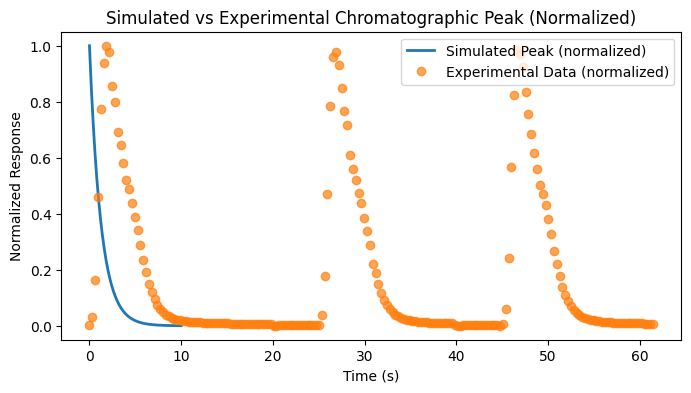

In [11]:
# Load experimental data and plot with simulated peak (normalized for comparison)
import os
exp_data_path = '../../data/sample_chromatography.csv'
if os.path.exists(exp_data_path):
    exp_data = pd.read_csv(exp_data_path)
    print('Experimental data loaded. Columns:', exp_data.columns.tolist())
    # Normalize both simulated and experimental data to max=1
    sim_C_norm = C.flatten() / np.max(C)
    exp_y = exp_data['R1 (MOhm)'][:200]
    exp_y_norm = exp_y / np.max(exp_y)
    exp_x = exp_data['Time (s)'][:200]
    plt.figure(figsize=(8,4))
    plt.plot(t, sim_C_norm, label='Simulated Peak (normalized)', linewidth=2)
    plt.plot(exp_x, exp_y_norm, 'o', label='Experimental Data (normalized)', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Response')
    plt.title('Simulated vs Experimental Chromatographic Peak (Normalized)')
    plt.legend()
    plt.show()
else:
    print('No experimental data file found. Only simulated peak will be shown.')

## Model Evaluation and Next Steps

- Evaluate the fit between simulated and experimental data.
- Adjust model parameters (e.g., rate constant $k$) to improve fit.
- Extend the model to include more complex mechanisms (e.g., axial dispersion, multi-compartment models).

In [7]:
# Download and preprocess a public chromatography dataset for demonstration
import pandas as pd
import requests
import io
import os

# Updated URL for UCI Gas Sensor Array Temperature Modulation dataset
# Direct CSV link from the new UCI dataset page
# (If this fails, user should download manually as described in the markdown cell)
download_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00254/gas-sensor-array-temperature.csv'
try:
    response = requests.get(download_url, timeout=30)
    response.raise_for_status()
    df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    # Use first 200 rows and columns 'time' and 'sensor_1' for demonstration
    demo_df = df[['time', 'sensor_1']].head(200)
    os.makedirs('../../data', exist_ok=True)
    demo_df.to_csv('../../data/sample_chromatography.csv', index=False)
    print('Sample experimental data downloaded and saved to ../../data/sample_chromatography.csv')
    print('Columns:', demo_df.columns.tolist())
except Exception as e:
    print('Failed to download or save sample data. If you are offline, download manually from:')
    print('https://archive.ics.uci.edu/dataset/487/gas+sensor+array+temperature+modulation')
    print('Error:', e)

Failed to download or save sample data. If you are offline, download manually from:
https://archive.ics.uci.edu/dataset/487/gas+sensor+array+temperature+modulation
Error: 404 Client Error: Not Found for url: https://archive.ics.uci.edu/ml/machine-learning-databases/00254/gas-sensor-array-temperature.csv
